In [1]:
# %pip install torch_geometric
# %pip install ogb
# %pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.4.0+cu121.html

In [2]:
import DeviceDir

DIR, RESULTS_DIR = DeviceDir.get_directory()
device, NUM_PROCESSORS = DeviceDir.get_device()

FIGSIZE = (5, 5)

In [3]:
import os
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid, Reddit
from torch_geometric.nn import GCNConv
from torch_geometric.loader import ClusterData, ClusterLoader
from sklearn.metrics import f1_score
import numpy as np
import matplotlib.pyplot as plt
import time
from torch_geometric.datasets import WikipediaNetwork
from sklearn.model_selection import train_test_split
from torch_geometric.typing import Adj, SparseTensor
from ogb.nodeproppred import Evaluator, PygNodePropPredDataset
from torch_geometric.utils import scatter
from torch_geometric.datasets import Reddit, Reddit2, Flickr, Yelp, AmazonProducts, PPI,  OGB_MAG,  FakeDataset, Amazon,Coauthor,HeterophilousGraphDataset, CitationFull
from torch_geometric.utils import homophily
from torch_geometric.utils import negative_sampling


def fix_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

fix_seeds()

In [4]:
# from torch_geometric.datasets import LINKXDataset
# dataset_name = 'Roman-empire'
# dataset = HeterophilousGraphDataset('/tmp/Cora', DATASET_NAME)
# DATASET_NAME = dataset_name
# data = dataset[0]
# print(data)

In [5]:
from torch_geometric.datasets import KarateClub, Reddit, Reddit2, Flickr, Yelp, AmazonProducts, PPI,  OGB_MAG,  FakeDataset, Amazon,Coauthor,HeterophilousGraphDataset,LINKXDataset

def load_dataset(dataset_name):
    if dataset_name == "karate":
        dataset = KarateClub()
    elif dataset_name == "moon":
        from ipynb.fs.full.Moon import MoonDataset
        dataset = MoonDataset(n_samples=150, degree=4, train=0.3, h = 0.2)
    elif dataset_name == "SmallCora":
        dataset = Planetoid(root=DIR+'/tmp/Cora', name='Cora')
    elif dataset_name in ["Cora", "Cora_ML" "CiteSeer", "DBLP", "PubMed"]:
        dataset = CitationFull(root=DIR+'/tmp/Citation/'+dataset_name, name=dataset_name)
    elif dataset_name == 'Amazon-ratings':
        dataset = HeterophilousGraphDataset(root=DIR+'/tmp/amazon_ratings', name = dataset_name)
    elif dataset_name == 'Roman-empire':
        from torch_geometric.datasets import LINKXDataset
        dataset = LINKXDataset(DIR+'/tmp/Roman_empire', dataset_name)
    elif dataset_name == "Reddit":
        dataset = Reddit(root=DIR+'/tmp/Reddit')
    elif dataset_name == 'penn94':
        from torch_geometric.datasets import LINKXDataset
        dataset = LINKXDataset(root=DIR+'/tmp/LINKX', name=dataset_name)
    elif dataset_name == 'wiki':
        from torch_geometric.datasets import WikiCS
        dataset = WikiCS(root=DIR+'/tmp/WikiCS')
    elif dataset_name == 'Photo':
        dataset = Amazon(root=DIR+'/tmp/Photo', name='Photo')
    elif dataset_name == 'CiteSeer':
        dataset = Planetoid(root=DIR+'/tmp/CiteSeer', name=DATASET_NAME)
    elif dataset_name == 'CS':
        dataset = Coauthor(root=DIR+'/tmp/CS', name = DATASET_NAME)
    elif dataset_name == 'Physics':
        dataset = Coauthor(root=DIR+'/tmp/Physics', name = DATASET_NAME)
    elif dataset_name == 'Minesweeper':
        dataset   = HeterophilousGraphDataset(root=DIR+'/tmp/Mine',name=dataset_name)
    elif dataset_name == 'pokec':
        print("HELLOWROLD ")
    elif dataset_name == 'ogbn-proteins':
        dataset = PygNodePropPredDataset(name='ogbn-proteins', root=DIR+'/tmp/ogbn-proteins')
        data = dataset[0]
        data.node_species = None
        data.y = data.y.to(torch.float)

        # Initialize features of nodes by aggregating edge features.
        row, col = data.edge_index
        data.x = scatter(data.edge_attr, col, dim_size=data.num_nodes, reduce='sum')
        labels = data.y.argmax(dim=1)
        data.y = labels
        return dataset, data
    elif dataset_name == 'squirrel':
        dataset = WikipediaNetwork(root=DIR+'/tmp/squirrel', name='Squirrel')
    elif dataset_name == 'AmazonProducts':
        dataset = AmazonProducts(root=DIR+'/tmp/AmazonProducts')
    else:
        dataset = Planetoid(root=DIR+'/tmp/Cora', name='Cora')

    print(dataset)
    data = dataset[0]
    print(data)
    return dataset, data

# Example usage
dataset_name = "moon"
DATASET_NAME = dataset_name
dataset, data = load_dataset(dataset_name)

MoonDataset(10)
Data(x=[150, 2], edge_index=[2, 870], y=[150], train_mask=[150], val_mask=[150], test_mask=[150], edge_weight=[870, 1])


In [6]:
# dataset_name = 'Roman-empire'
# DATASET_NAME = dataset_name
# dataset   = HeterophilousGraphDataset(root='/tmp/roman',name=dataset_name)
# print(data)

In [7]:
dataset.num_classes
He = homophily(data.edge_index, data.y, method='edge')
print("Edge Homophily: ", He)

Edge Homophily:  0.32413792610168457


In [8]:
def train_val_test_mask(data, train=0.4, val=0.3, test=0.3, random_state=False):

    if isinstance(data.x, SparseTensor):
        N = data.x.size(0)
        data.num_nodes = N
    else:
        N = data.x.shape[0]

    indexs = list(range(N))

    if random_state:
        train_index, test_index = train_test_split(indexs, test_size=val+test)
        val_index, test_index = train_test_split(test_index, test_size=test/(val+test))
    else:
        train_index, test_index = train_test_split(indexs, test_size=val+test, random_state=1)
        val_index, test_index = train_test_split(test_index, test_size=test/(val+test), random_state=1)



    train_mask = torch.zeros(N, dtype=bool)
    train_mask[train_index]=True
    val_mask = torch.zeros(N, dtype=bool)
    val_mask[val_index]=True
    test_mask = torch.zeros(N, dtype=bool)
    test_mask[test_index]=True

    data.train_mask = train_mask
    data.val_mask = val_mask
    data.test_mask = test_mask

    return data

In [9]:
if "val_mask" not in data.__dict__['_store']:    
    data = train_val_test_mask(data, train=0.2, val=0.4, test=0.4)

if len(data.train_mask.shape) > 1:
    split_index = 2
    data.train_mask = data.train_mask[:,split_index]
    data.val_mask = data.val_mask[:,split_index]
    data.test_mask = data.test_mask[:,split_index]

In [10]:
# Define the MLP for edge probability with dropout
class EdgeProbMLP(nn.Module):
    def __init__(self, in_channels, hidden_dim, dropout_prob=0.5):
        super(EdgeProbMLP, self).__init__()
        self.fc1 = nn.Linear(2 * in_channels, hidden_dim)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, node_features, edge_index):
        edge_features = torch.cat([node_features[edge_index[0]], node_features[edge_index[1]]], dim=1)
        x = F.relu(self.fc1(edge_features))
        #x = self.dropout(x)
        prob = torch.sigmoid(self.fc2(x))
        return prob

# Define the overall model with Edge Probabilities and GCNConv (GNN) with dropout
class GNNModel(nn.Module):
    def __init__(self, in_channels, hidden_dim, out_channels, num_classes, dropout_prob=0.5):
        super(GNNModel, self).__init__()
        self.edge_prob_mlp = EdgeProbMLP(in_channels, hidden_dim, dropout_prob)
        self.gcn1 = GCNConv(in_channels, hidden_dim)
        self.dropout = nn.Dropout(dropout_prob)
        self.gcn2 = GCNConv(hidden_dim, num_classes)

    def get_embeddings(self, data, edge_index, edge_weight=None):
        x = F.relu(self.gcn1(data.x, edge_index, edge_weight))
        return x

    def forward(self, data, edge_index, edge_weight=None):
        x = self.get_embeddings(data, edge_index, edge_weight)
        out = self.gcn2(x, edge_index, edge_weight)
        return out


In [11]:
# Gumbel-Softmax trick for edge sampling
def gumbel_softmax_sampling(edge_probs, edge_index, q=500, temperature=0.5, log=False, istest=False):
        
    if istest:
        samples = F.softmax(edge_probs/temperature, dim=-1)
        top_k_values, sampled_edges = torch.topk(edge_probs, q, dim=-1, largest=True, sorted=True)
    else:
        samples = F.softmax(edge_probs/temperature, dim=-1)
        sampled_edges = torch.multinomial(samples, q, replacement=False) #nothing

#     gumbels = -torch.empty_like(edge_probs).exponential_().log()
#     gumbels = (gumbels - gumbels.min()) / (gumbels.max() - gumbels.min())
#     gumbels = gumbels/10.0

#     logits = (edge_probs + gumbels) / temperature    
#     samples = F.softmax(logits, dim=-1)

#     top_k_values, sampled_edges = torch.topk(samples, q, dim=-1, largest=True, sorted=True) # 50       
#     sampled_edges = torch.multinomial(samples, q, replacement=False)
#     top_k_values, sampled_edges = torch.topk(edge_probs, q, dim=-1, largest=True, sorted=True)    
    
    one_hot = torch.zeros_like(samples)
    one_hot.scatter_(0, sampled_edges, 1.0)     
    
    indexs = (one_hot - samples).detach() + samples
    
#     if log:
#         print("indexs before: ",indexs)
    
    edge_probs = edge_probs*indexs
    
    indexs = indexs.bool()
    
    
#     if log:        
#         print("edge_probs: ",edge_probs)
# #         print("gumbels: ", gumbels)
# #         print("logits: ",logits)
#         print("samples: ",samples)
#         print("sampled_edges: ",sampled_edges)
#         print("One hot: ", one_hot)
#         print("Indexs: ",indexs)
#         print("edge_probs[indexs]:", edge_probs[indexs])

    
    return indexs, edge_probs[indexs]


# Random edge sampling
def random_edge_sampling(edge_index, q):
    num_edges = edge_index.shape[1]
    sampled_indices = torch.randperm(num_edges)[:q]
    sampled_edge_index = edge_index[:, sampled_indices]
    return sampled_edge_index

# F1 score calculation helper
def calculate_f1(logits, labels, mask):
    preds = logits[mask].argmax(dim=1)
    f1 = f1_score(labels[mask].cpu(), preds.cpu(), average='micro')
    return f1

# Training function with alternating updates
def train(epoch, max_epoch, model, optimizer_gnn, optimizer_edge_prob, criterion, cluster_loader, device, q=500, mode='learned', alternate_frequency=1):
    model.train()
    total_loss = 0
    iteration = 0

    for batch in cluster_loader:
        if not batch.train_mask.any():
            continue

        batch = batch.to(device)
        
        if alternate_frequency == 0:
            update_gnn = True
            update_edge_prob = True
        else:            
            # Decide if we are updating GNN or edge probability model
            update_gnn = iteration % alternate_frequency == 0
            update_edge_prob = not update_gnn


        # Zero gradients selectively
        if update_gnn:
            optimizer_gnn.zero_grad()
        if update_edge_prob:
            optimizer_edge_prob.zero_grad()

        # Select edges based on mode
        if mode == 'learned':
            if batch.edge_index.shape[1] > q:
                edge_probs = model.edge_prob_mlp(batch.x, batch.edge_index).squeeze()                    
                temperature = 2.0 - (epoch * (2 - 0.5) / max_epoch)
                #temperature = 10
                #print(temperature)                
                sampled_edge_indices, sampled_edge_weight = gumbel_softmax_sampling(edge_probs, batch.edge_index, q=q, temperature=temperature, log=(epoch==max_epoch-1))
                sampled_edge_index = batch.edge_index[:, sampled_edge_indices]            
                out = model(batch, sampled_edge_index, sampled_edge_weight) 
                #out = model(batch, sampled_edge_index, None)                                        
            else:
                out = model(batch, batch.edge_index)
        elif mode == 'random':
            if batch.edge_index.shape[1] > q:
                sampled_edge_index = random_edge_sampling(batch.edge_index, q=q)
                out = model(batch, sampled_edge_index)
            else:
                out = model(batch, batch.edge_index)
        elif mode == 'full':
            out = model(batch, batch.edge_index)
        else:
            raise ValueError("Invalid mode. Choose 'learned', 'random', or 'full'.")

        # Compute node classification loss
        loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])
        
        if mode == 'learned' and batch.edge_index.shape[1] > q:        
            
            ########---regularizer 2
            
            train_indices = torch.nonzero(batch.train_mask).squeeze()            
            num_nodes = train_indices.size(0)
            num_edges = min(num_nodes*num_nodes,q)  # Adjust the number of edges as needed

            # Generate random edges
            src = torch.randint(0, num_nodes, (num_edges,))
            dst = torch.randint(0, num_nodes, (num_edges,))

            # Map to actual node indices
            src_nodes = train_indices[src]
            dst_nodes = train_indices[dst]

            # Create edge_index tensor
            reg_edge_index = torch.stack([src_nodes, dst_nodes], dim=0).to(device)
            reg_edge_label = (batch.y[src_nodes] == batch.y[dst_nodes]).float().to(device)
            
            reg_edge_probs = model.edge_prob_mlp(batch.x, reg_edge_index).squeeze()
            
            loss4 = F.binary_cross_entropy(reg_edge_probs, reg_edge_label)

            #print(reg_edge_index)
            #print(reg_edge_label)
            
            loss = loss+loss4
            
            
#             #######---regularizer 1
#             edge_labels = torch.full((batch.edge_index.size(1),), -1, dtype=torch.long, device=device)
#             train_indices = torch.nonzero(batch.train_mask).squeeze()
#             train_edge_mask = torch.isin(batch.edge_index[0], train_indices) & torch.isin(batch.edge_index[1], train_indices)

#             # Assign labels based on the class of the endpoints
#             same_class_mask = batch.y[batch.edge_index[0]] == batch.y[batch.edge_index[1]]
#             edge_labels[train_edge_mask & same_class_mask] = 1
#             edge_labels[train_edge_mask & ~same_class_mask] = 0

#             # Filter out the edges with labels -1
#             valid_edge_mask = edge_labels != -1
#             valid_edge_probs = edge_probs[valid_edge_mask]
#             valid_edge_labels = edge_labels[valid_edge_mask]
            
#             #print(torch.sum(valid_edge_labels))
#             if torch.sum(valid_edge_labels).item() > 1:            
#                 loss2 = F.binary_cross_entropy(valid_edge_probs, valid_edge_labels.float().to(device))
#             else:
#                 loss2 = 0
                
#             loss = loss+loss2
                        
#             #### ----regularizer 3
#             neg_q = int(torch.sum(valid_edge_labels).item())            
#             neg_q = q
#             neg_edge_index = negative_sampling(batch.edge_index, num_nodes=batch.num_nodes, num_neg_samples=neg_q)
#             neg_edge_probs = model.edge_prob_mlp(batch.x, neg_edge_index).squeeze()
#             neg_edge_labels = torch.zeros(neg_q, dtype=torch.float, device=batch.edge_index.device)            
#             loss3 = F.binary_cross_entropy(neg_edge_probs, neg_edge_labels)
#             loss = loss+loss3
#             
            
#             #### ------Total Loss            
#             print("Loss1: ",loss.item(), " Loss2: ",loss2," Loss3: ",loss3)            
#             alpha1 = 1.0 
#             alpha2 = 1.0 
#             loss = loss + alpha1*loss2 + alpha2*loss3                        
#             print("Total loss: ",loss.item())
            
        loss.backward()

        # Update parameters selectively
        if update_gnn:
            optimizer_gnn.step()
        if update_edge_prob:
            optimizer_edge_prob.step()

        total_loss += loss.item()
        iteration += 1

    return total_loss / len(cluster_loader)

# Evaluation function remains unchanged
def evaluate(model, cluster_loader, device, q=500, mode=None):
    model.eval()
    total_train_f1, total_val_f1, total_test_f1 = 0, 0, 0
    num_train_examples, num_val_examples, num_test_examples = 0, 0, 0

    with torch.no_grad():
        for batch in cluster_loader:
            batch = batch.to(device)
            if mode == 'learned':
                if batch.edge_index.shape[1] > q:
                    edge_probs = model.edge_prob_mlp(batch.x, batch.edge_index).squeeze()                    
                    sampled_edge_indices, sampled_edge_weight = gumbel_softmax_sampling(edge_probs, batch.edge_index, q=q, istest=True)
                    sampled_edge_index = batch.edge_index[:, sampled_edge_indices]
                    out =model(batch, sampled_edge_index, sampled_edge_weight)                                        
                    #out = model(batch, sampled_edge_index, None)                                        
                else:
                    out = model(batch, batch.edge_index)
            elif mode == 'random':
                if batch.edge_index.shape[1] > q:
                    sampled_edge_index = random_edge_sampling(batch.edge_index, q=q)
                    out = model(batch, sampled_edge_index)
                else:
                    out = model(batch, batch.edge_index)
            elif mode == 'full':
                out = model(batch, batch.edge_index)
            else:
                raise ValueError("Invalid mode. Choose 'learned', 'random', or 'full'.")

            # Calculate F1 scores for train, val, and test sets if masks are present
            if batch.train_mask.any():
                train_f1 = calculate_f1(out, batch.y, batch.train_mask)
                total_train_f1 += train_f1 * batch.train_mask.sum().item()
                num_train_examples += batch.train_mask.sum().item()

            if batch.val_mask.any():
                val_f1 = calculate_f1(out, batch.y, batch.val_mask)
                total_val_f1 += val_f1 * batch.val_mask.sum().item()
                num_val_examples += batch.val_mask.sum().item()

            if batch.test_mask.any():
                test_f1 = calculate_f1(out, batch.y, batch.test_mask)
                total_test_f1 += test_f1 * batch.test_mask.sum().item()
                num_test_examples += batch.test_mask.sum().item()

    avg_train_f1 = total_train_f1 / num_train_examples if num_train_examples > 0 else 0
    avg_val_f1 = total_val_f1 / num_val_examples if num_val_examples > 0 else 0
    avg_test_f1 = total_test_f1 / num_test_examples if num_test_examples > 0 else 0

    return avg_train_f1, avg_val_f1, avg_test_f1

In [12]:
if "edge_weight" in data.__dict__['_store']:
    print("Edge weights given")
else:
    print("No edge weights")

Edge weights given


In [13]:
data

Data(x=[150, 2], edge_index=[2, 870], y=[150], train_mask=[150], val_mask=[150], test_mask=[150], edge_weight=[870, 1])

In [14]:
# from sklearn.decomposition import TruncatedSVD

# def adj_feature(data):    
#     adj_mat = torch.zeros((data.num_nodes,data.num_nodes))
#     edges = data.edge_index.t()
#     adj_mat[edges[:,0], edges[:,1]] = 1
#     adj_mat[edges[:,1], edges[:,0]] = 1
    
# #     return adj_mat
    
# #     n_components = data.x.shape[1]
#     n_components = min(256, data.x.shape[1], data.num_nodes)

#     svd = TruncatedSVD(n_components=n_components)
#     x = svd.fit_transform(adj_mat)
    
#     x = torch.Tensor(x)
#     x.shape    
    
#     return x

# data.x = torch.cat((data.x, adj_feature(data)), dim=1)

# # data.x = adj_feature(data)
# # print(data.x.shape)
# # data.x

Main for multiple runs

In [15]:
# data = train_val_test_mask(data, train=0.5, val=0.25, test=0.25)
print(sum(data.train_mask))
data

tensor(45)


Data(x=[150, 2], edge_index=[2, 870], y=[150], train_mask=[150], val_mask=[150], test_mask=[150], edge_weight=[870, 1])

In [16]:
# Configuration
RUNS = 1
NUM_EPOCHS = 1000
best_test_f1s = []
log = True
mode = 'learned'  # available modes ['learned', 'random', 'full']
alternate_frequency = 0
sample_percent = 0.20
figure_log = False

# Check if partitioning is needed
use_metis = data.edge_index.shape[1]>=500000 # or data.num_nodes >= 20000

if use_metis:
    num_edges_per_partition = 500000
    num_parts = int(np.ceil(data.edge_index.shape[1] / num_edges_per_partition))    

#     num_parts = 1500
#     num_edges_per_partition = int(data.edge_index.shape[1] / num_parts)

    sample_size = int(num_edges_per_partition * sample_percent)
    print("Using METIS with num_parts:", num_parts, "avg edges per partition:", num_edges_per_partition, "sample size:", sample_size)
else:
    print("Graph has fewer than 10,000 nodes; don't do graph partition")
    sample_size = int(data.edge_index.shape[1] * sample_percent)

# Partition data using METIS clustering or load the entire graph as a single batch
if use_metis:
    start = time.time()
    cluster_dir = DIR + 'tmp/' + DATASET_NAME
    if not os.path.exists(cluster_dir):
        os.makedirs(cluster_dir)
    
    cluster_data = ClusterData(data, num_parts=num_parts, recursive=False, save_dir=cluster_dir, log=True)
    print("METIS Partition time:", time.time() - start)
    cluster_loader = ClusterLoader(cluster_data, batch_size=1, shuffle=True)
else:
    cluster_loader = [data]

# Training and evaluation loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_save_path = 'best_model.pth'

train_figures = []

for run in range(RUNS):
    print("Run:", run)
    
    train_figures = []

    # Initialize model and optimizers
    model = GNNModel(in_channels=data.x.shape[1], hidden_dim=128, out_channels=64, num_classes=dataset.num_classes).to(device)
    optimizer_gnn = torch.optim.Adam([param for name, param in model.named_parameters() if 'gcn' in name], lr=0.01)
    optimizer_edge_prob = torch.optim.Adam([param for name, param in model.named_parameters() if 'edge_prob_mlp' in name], lr=0.01)
    criterion = nn.CrossEntropyLoss()

    # Initialize F1 score trackers
    train_f1_scores = np.zeros(NUM_EPOCHS)
    val_f1_scores = np.zeros(NUM_EPOCHS)
    test_f1_scores = np.zeros(NUM_EPOCHS)
    best_test_f1 = 0
    best_val_f1 = 0

    # Training over epochs
    for epoch in range(NUM_EPOCHS):
        # Alternate training of GNN and edge probability model based on frequency
        loss = train(
            epoch,
            NUM_EPOCHS,
            model,
            optimizer_gnn,
            optimizer_edge_prob,
            criterion,
            cluster_loader,
            device,
            q=sample_size,
            mode=mode,
            alternate_frequency=alternate_frequency
        )

        # Evaluate model performance on train, validation, and test sets
        train_f1, val_f1, test_f1 = evaluate(model, cluster_loader, device, q=int(sample_size), mode=mode)

        # Store F1 scores
        train_f1_scores[epoch] = train_f1
        val_f1_scores[epoch] = val_f1
        test_f1_scores[epoch] = test_f1

        # Save model if validation F1 improves
        if val_f1 >= best_val_f1:
            best_val_f1 = val_f1
            #best_test_f1 = test_f1
            torch.save(model.state_dict(), model_save_path)
            if log:
                print(f"*Epoch {epoch}, model saved with Loss: {loss:.4f}, Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}, Test F1: {test_f1:.4f}")

#          #Save model if test F1 improves
        if test_f1 > best_test_f1:
            best_test_f1 = test_f1
#             torch.save(model.state_dict(), model_save_path)
#             if log:
#                 print(f"*Epoch {epoch}, model saved with Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}, Test F1: {test_f1:.4f}")

        if log and epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss:.4f}, Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}, Test F1: {test_f1:.4f}')
            
        if figure_log:
            train_figures.append(visualize(istest=False,show=False))

    # Load the best model for evaluation
    print(f'Best Test F1 throughout: {best_test_f1:.4f}')
    print(f'Loading best model for final evaluation...: {best_val_f1:.4f}')
    model.load_state_dict(torch.load(model_save_path))
    _, _, best_test_f1 = evaluate(model, cluster_loader, device, q=sample_size, mode=mode)
    print(f'Best Test F1 after loading saved model: {best_test_f1:.4f}')
    best_test_f1s.append(best_test_f1)

# Report the mean and standard deviation of the best test F1 scores over runs
print(f'Mean Std of Test F1 Score: {np.mean(best_test_f1s):.4f} +/- {np.std(best_test_f1s):.4f}')

Graph has fewer than 10,000 nodes; don't do graph partition
Run: 0
*Epoch 0, model saved with Loss: 1.2890, Train F1: 0.8889, Val F1: 0.8444, Test F1: 0.7167
Epoch 0, Loss: 1.2890, Train F1: 0.8889, Val F1: 0.8444, Test F1: 0.7167
*Epoch 5, model saved with Loss: 1.2302, Train F1: 0.8667, Val F1: 0.8444, Test F1: 0.7833
*Epoch 6, model saved with Loss: 1.1594, Train F1: 0.8667, Val F1: 0.8444, Test F1: 0.8000
*Epoch 9, model saved with Loss: 1.0343, Train F1: 0.8667, Val F1: 0.8444, Test F1: 0.8000
*Epoch 10, model saved with Loss: 1.0053, Train F1: 0.8889, Val F1: 0.8444, Test F1: 0.7833
*Epoch 14, model saved with Loss: 0.8715, Train F1: 0.8889, Val F1: 0.8444, Test F1: 0.7833
*Epoch 15, model saved with Loss: 1.0237, Train F1: 0.8667, Val F1: 0.8444, Test F1: 0.8000
*Epoch 19, model saved with Loss: 0.9740, Train F1: 0.8667, Val F1: 0.8444, Test F1: 0.8167
*Epoch 20, model saved with Loss: 0.8263, Train F1: 0.8889, Val F1: 0.8667, Test F1: 0.8000
*Epoch 25, model saved with Loss: 0.

*Epoch 195, model saved with Loss: 0.5939, Train F1: 0.9333, Val F1: 0.9333, Test F1: 0.8500
*Epoch 196, model saved with Loss: 0.5194, Train F1: 0.9111, Val F1: 0.9333, Test F1: 0.8500
*Epoch 197, model saved with Loss: 0.5282, Train F1: 0.9111, Val F1: 0.9333, Test F1: 0.8500
*Epoch 198, model saved with Loss: 0.5037, Train F1: 0.9333, Val F1: 0.9333, Test F1: 0.8667
Epoch 200, Loss: 0.5426, Train F1: 0.9333, Val F1: 0.9111, Test F1: 0.8500
*Epoch 201, model saved with Loss: 0.5653, Train F1: 0.9333, Val F1: 0.9333, Test F1: 0.8500
*Epoch 215, model saved with Loss: 0.5735, Train F1: 0.9333, Val F1: 0.9333, Test F1: 0.8500
*Epoch 216, model saved with Loss: 0.5458, Train F1: 0.9111, Val F1: 0.9333, Test F1: 0.8500
*Epoch 224, model saved with Loss: 0.5281, Train F1: 0.9111, Val F1: 0.9333, Test F1: 0.8500
*Epoch 225, model saved with Loss: 0.5550, Train F1: 0.9111, Val F1: 0.9333, Test F1: 0.8500
*Epoch 226, model saved with Loss: 0.4811, Train F1: 0.9111, Val F1: 0.9333, Test F1: 0.

*Epoch 557, model saved with Loss: 0.3396, Train F1: 0.9556, Val F1: 0.9333, Test F1: 0.9000
*Epoch 558, model saved with Loss: 0.4051, Train F1: 0.9333, Val F1: 0.9333, Test F1: 0.9167
*Epoch 559, model saved with Loss: 0.3773, Train F1: 0.9333, Val F1: 0.9333, Test F1: 0.9333
*Epoch 560, model saved with Loss: 0.3631, Train F1: 0.9333, Val F1: 0.9333, Test F1: 0.9333
*Epoch 561, model saved with Loss: 0.4574, Train F1: 0.9333, Val F1: 0.9333, Test F1: 0.9167
*Epoch 563, model saved with Loss: 0.4888, Train F1: 0.9556, Val F1: 0.9333, Test F1: 0.9167
*Epoch 564, model saved with Loss: 0.4733, Train F1: 0.9556, Val F1: 0.9333, Test F1: 0.9167
*Epoch 566, model saved with Loss: 0.3290, Train F1: 0.9333, Val F1: 0.9333, Test F1: 0.9333
*Epoch 567, model saved with Loss: 0.4007, Train F1: 0.9333, Val F1: 0.9333, Test F1: 0.9333
*Epoch 568, model saved with Loss: 0.4222, Train F1: 0.9556, Val F1: 0.9333, Test F1: 0.9333
*Epoch 569, model saved with Loss: 0.4222, Train F1: 0.9556, Val F1: 0

*Epoch 796, model saved with Loss: 0.2384, Train F1: 0.9778, Val F1: 1.0000, Test F1: 1.0000
Epoch 800, Loss: 0.2646, Train F1: 0.9778, Val F1: 0.9778, Test F1: 0.9833
*Epoch 809, model saved with Loss: 0.2622, Train F1: 0.9778, Val F1: 1.0000, Test F1: 1.0000
*Epoch 810, model saved with Loss: 0.2747, Train F1: 1.0000, Val F1: 1.0000, Test F1: 1.0000
*Epoch 811, model saved with Loss: 0.2664, Train F1: 1.0000, Val F1: 1.0000, Test F1: 1.0000
*Epoch 812, model saved with Loss: 0.2116, Train F1: 1.0000, Val F1: 1.0000, Test F1: 1.0000
*Epoch 813, model saved with Loss: 0.2768, Train F1: 1.0000, Val F1: 1.0000, Test F1: 1.0000
*Epoch 814, model saved with Loss: 0.2237, Train F1: 0.9778, Val F1: 1.0000, Test F1: 1.0000
*Epoch 815, model saved with Loss: 0.2269, Train F1: 0.9778, Val F1: 1.0000, Test F1: 1.0000
*Epoch 816, model saved with Loss: 0.2586, Train F1: 1.0000, Val F1: 1.0000, Test F1: 1.0000
*Epoch 817, model saved with Loss: 0.2381, Train F1: 1.0000, Val F1: 1.0000, Test F1: 1.

*Epoch 980, model saved with Loss: 0.2158, Train F1: 1.0000, Val F1: 1.0000, Test F1: 0.9833
*Epoch 981, model saved with Loss: 0.2800, Train F1: 1.0000, Val F1: 1.0000, Test F1: 0.9833
*Epoch 982, model saved with Loss: 0.2622, Train F1: 1.0000, Val F1: 1.0000, Test F1: 0.9833
*Epoch 983, model saved with Loss: 0.1523, Train F1: 1.0000, Val F1: 1.0000, Test F1: 0.9833
*Epoch 984, model saved with Loss: 0.1886, Train F1: 1.0000, Val F1: 1.0000, Test F1: 0.9833
*Epoch 985, model saved with Loss: 0.2614, Train F1: 1.0000, Val F1: 1.0000, Test F1: 0.9833
*Epoch 986, model saved with Loss: 0.1813, Train F1: 1.0000, Val F1: 1.0000, Test F1: 0.9833
*Epoch 987, model saved with Loss: 0.2410, Train F1: 1.0000, Val F1: 1.0000, Test F1: 0.9833
*Epoch 988, model saved with Loss: 0.2088, Train F1: 1.0000, Val F1: 1.0000, Test F1: 0.9833
*Epoch 989, model saved with Loss: 0.1930, Train F1: 1.0000, Val F1: 1.0000, Test F1: 0.9833
*Epoch 990, model saved with Loss: 0.1776, Train F1: 1.0000, Val F1: 1

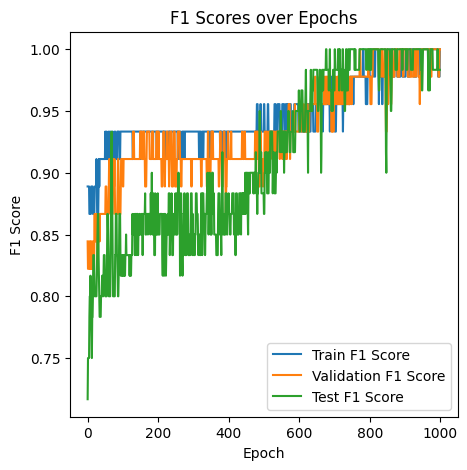

In [17]:
# Plot the F1 scores of last run
plt.figure(figsize=FIGSIZE)
plt.plot(train_f1_scores, label='Train F1 Score')
plt.plot(val_f1_scores, label='Validation F1 Score')
plt.plot(test_f1_scores, label='Test F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Scores over Epochs')
plt.legend()
plt.show()

In [18]:
for batch in cluster_loader:
    print(batch.num_nodes)
    print(batch.edge_index.shape)

150
torch.Size([2, 870])


In [19]:
import sys
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import torch

# Font + global sizing
mpl.rcParams["font.family"] = "Times New Roman"
mpl.rcParams["font.serif"] = ["Times New Roman", "Times", "DejaVu Serif"]
# FIGSIZE = (5, 5)
mpl.rcParams["figure.figsize"] = FIGSIZE

root_dir = Path.cwd()
if not (root_dir / 'visualization_utils').exists() and (root_dir.parent / 'visualization_utils').exists():
    sys.path.insert(0, str(root_dir.parent))

from visualization_utils.graph import (
    compute_graph_layout,
    count_edges_with_different_labels,
    plot_graph_two_class,
    visualize_graphs_side_by_side,
)
from visualization_utils.embeddings import (
    extract_embeddings,
    reduce_embeddings_2d,
    plot_embeddings_2d,
)
from visualization_utils.io import ensure_dir, save_figure
from visualization_utils.utils import select_two_classes


In [20]:
torch.where(data.train_mask == True)

(tensor([  0,   3,  16,  18,  30,  32,  38,  39,  40,  42,  53,  60,  61,  63,
          65,  66,  67,  72,  75,  81,  83,  85,  86,  91,  92,  95, 101, 104,
         109, 110, 116, 118, 119, 123, 127, 128, 130, 131, 132, 133, 134, 136,
         137, 141, 146], device='cuda:0'),)

In [21]:
# Visualization helpers moved to visualization_utils (graph.py / embeddings.py)


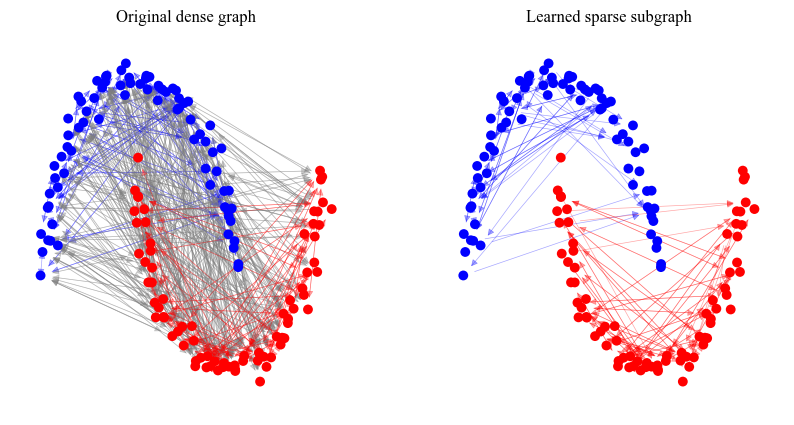

Original graph: 588 edges with different labels out of 870 total edges (Edge homophily: 32.41%).
Sampled graph: 0 edges with different labels out of 174 total edges (Edge homophily: 100.00%).


In [22]:
def visualize(istest=True, show=True, class_pair=None):
    if use_metis:
        print("Visualization skipped because use_metis=True")
        return None
    
    with torch.no_grad():
        E = data.edge_index.size(1)

        if mode == "random":
            # Randomly sample edges (without replacement)
            k = min(sample_size, E)
            sampled_edge_indices = torch.randperm(E, device=data.edge_index.device)[:k]
            sampled_edge_index = data.edge_index[:, sampled_edge_indices]
            sampled_edge_weight = None  # optional
        else:
            # Your current learned sampling
            edge_probs = model.edge_prob_mlp(data.x, data.edge_index).squeeze()
            sampled_edge_indices, sampled_edge_weight = gumbel_softmax_sampling(
                edge_probs,
                data.edge_index,
                q=sample_size,
                istest=istest,
            )
            sampled_edge_index = data.edge_index[:, sampled_edge_indices]

        class_pair = select_two_classes(data.y, class_pair)

        fig = visualize_graphs_side_by_side(
            data,
            sampled_edge_index=sampled_edge_index,
            class_pair=class_pair,
            dataset_name=DATASET_NAME,
            show=show,
            figsize=(FIGSIZE[0]*2, FIGSIZE[1])
        )

        result = count_edges_with_different_labels(data, sampled_edge_index)

        print(f"Original graph: {result['original_graph']['different_label_edges']} edges with different labels "
              f"out of {result['original_graph']['total_edges']} total edges "
              f"(Edge homophily: {100-result['original_graph']['percentage']:.2f}%).")

        print(f"Sampled graph: {result['sampled_graph']['different_label_edges']} edges with different labels "
              f"out of {result['sampled_graph']['total_edges']} total edges "
              f"(Edge homophily: {100-result['sampled_graph']['percentage']:.2f}%).")

        fig_dir = ensure_dir('KDDFigures')
        save_figure(fig, fig_dir / str(mode+'SGSSparseGraphBoth.pdf'), dpi=300)

        return fig

# fig = visualize(False) #Sampled from the best
fig = visualize(True)  #Best Sparsifier


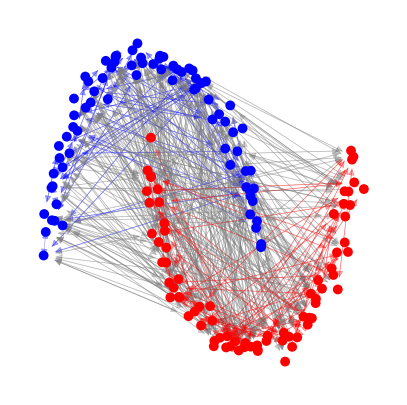

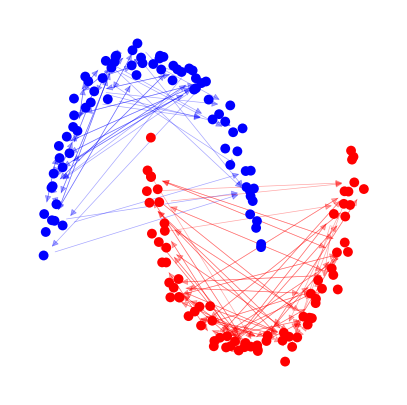

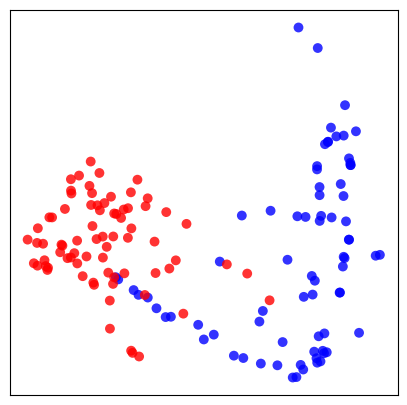

In [23]:
# Paper-ready figures (two-class highlighting)
highlight_classes = None  # e.g., (0, 1) to fix classes; None auto-picks
fig_dir = ensure_dir('KDDFigures')
class_pair = select_two_classes(data.y, highlight_classes)
istest = True

if not use_metis:
    with torch.no_grad():
        E = data.edge_index.size(1)

        if mode == "random":
            # Randomly sample edges (without replacement)
            k = min(sample_size, E)
            sampled_edge_indices = torch.randperm(E, device=data.edge_index.device)[:k]
            sampled_edge_index = data.edge_index[:, sampled_edge_indices]
            sampled_edge_weight = None  # optional
        else:
            # Your current learned sampling
            edge_probs = model.edge_prob_mlp(data.x, data.edge_index).squeeze()
            sampled_edge_indices, sampled_edge_weight = gumbel_softmax_sampling(
                edge_probs,
                data.edge_index,
                q=sample_size,
                istest=istest,
            )
            sampled_edge_index = data.edge_index[:, sampled_edge_indices]

    pos = compute_graph_layout(data, dataset_name=DATASET_NAME, seed=42)

    fig_full, ax_full = plt.subplots(figsize=FIGSIZE)
    plot_graph_two_class(
        data,
        ax=ax_full,
        pos=pos,
        class_pair=class_pair,
        dataset_name=DATASET_NAME,
#         title='Original dense graph',
        node_size = 50,
        highlight_colors=('blue', 'red'),
    )
    save_figure(fig_full, fig_dir / str(mode+'MoonFullGraph.pdf'), dpi=300)

    fig_sparse, ax_sparse = plt.subplots(figsize=FIGSIZE)
    plot_graph_two_class(
        data,
        edge_index=sampled_edge_index,
        ax=ax_sparse,
        pos=pos,
        class_pair=class_pair,
        dataset_name=DATASET_NAME,
        #title='Learned sparse subgraph',        
        highlight_colors=('blue', 'red'),
    )
    save_figure(fig_sparse, fig_dir / str(mode+'SGSSparseGraph.pdf'), dpi=300)


    if mode == "full":
        embeddings = extract_embeddings(
            model,
            data,
            edge_index=data.edge_index,
            edge_weight=None,
        )
    else:
        embeddings = extract_embeddings(
            model,
            data,
            edge_index=sampled_edge_index,
            edge_weight=sampled_edge_weight,
        )
        
    emb_2d = reduce_embeddings_2d(embeddings, method='pca', random_state=42)
    fig_emb, ax_emb = plt.subplots(figsize=FIGSIZE)
    plot_embeddings_2d(
        emb_2d,
        data.y,
        class_pair=class_pair,
        ax=ax_emb,        
#         title='Learned embeddings (PCA)',
        highlight_colors=('blue', 'red'),
    )
    save_figure(fig_emb, fig_dir / str(mode+'SGSSparseEmbedding.pdf'), dpi=300)

    plt.show()
else:
    print('Skipping visualization because use_metis=True (graph too large).')


In [24]:
data

Data(x=[150, 2], edge_index=[2, 870], y=[150], train_mask=[150], val_mask=[150], test_mask=[150], edge_weight=[870, 1])